In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

Using TensorFlow backend.


In [2]:
def scale_training_data(X_train, Y_train):
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train_s = x_scaler.fit_transform(X_train)
    Y_train_s = y_scaler.fit_transform(Y_train)
    
    return X_train_s, Y_train_s, x_scaler, y_scaler

In [3]:
def train_test_split(X_train, Y_train, train_portion):

    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]
    
    return x_train, y_train, x_test, y_test

In [20]:
def baseline_model(input_dim, output_dim, height):
    model = Sequential()
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    adam = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=adam)
    
    earlystop = EarlyStopping(monitor='loss', min_delta=0.000001, patience=10, verbose=1, mode='auto')
    callback_list = [earlystop]
    return model, callback_list

In [5]:
def prepare_training_data(df_F, df_D, df_Dt, d, t):

    D = df_D.values
    Dt = df_Dt.values
    F = df_F.values
    dim = np.shape(D)

    n_timesteps, n_nodes = dim
    x = np.linspace(0,1, n_nodes)

    X_train = np.zeros([n_timesteps-d, 3*d*n_nodes])
    Y_train = np.zeros([n_timesteps-d, 2*n_nodes])


    for k in range(n_timesteps-d):

        bulk = 0
        for j in range(n_nodes):
            X_train[k, bulk:bulk + d] = F[t-d:t,j]    
            bulk += d

        for j in range(n_nodes):
            X_train[k, bulk:bulk + d] = D[t-d:t,j]
            bulk += d

        for j in range(n_nodes):
            X_train[k, bulk: bulk + d] = Dt[t-d:t,j]
            bulk += d

        Y_train[k, 0:n_nodes] = D[t, :]
        Y_train[k, n_nodes:] = Dt[t, :]
        t += 1
        
    return X_train, Y_train, n_timesteps, n_nodes, x

In [6]:
def get_error(predictions, y_test):
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [7]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:])

    dz = np.copy(input_i[d*n_nodes:])

    dz = np.reshape(dz, (n_nodes*2, d))


    #dzt = np.copy(input_i[d+1+n_nodes*d:])
    #dzt = np.reshape(dzt, (n_nodes, d))

    preds = np.zeros([len(x_test[:,0])-1, n_nodes*2])
    force = np.copy(x_test[:, 0:d*n_nodes])

    for k in range(len(x_test[:,0])-1):


        pred = model.predict(np.reshape(input_i,(1,len(input_i))))
        preds[k, :] = pred

        input_i[0:d*n_nodes] = force[k+1,:]

        dz = np.delete(dz, 0, 1)
        dz = np.concatenate((dz, np.reshape(pred[0,:], (1,n_nodes*2)).T), axis=1)
        #dz[0,:] = np.zeros(d)
        #dzt = np.delete(dzt, 0, 1)
        #dzt = np.concatenate((dzt, np.reshape(pred[0,n_nodes:], (1, n_nodes)).T), axis=1)
        #dzt[0,:] = np.zeros(n_nodes)
        input_i[d*n_nodes:] = np.reshape(dz, (1, n_nodes*d*2))[0]
        #input_i[d+1+n_nodes*d:] = np.reshape(dzt, (1, n_nodes*d))[0]
    
    return preds


In [ ]:
########################### TRAIN FEED-FORWARD MODEL #################################

d = 10 #number of steps in "model memory"
t = d
n_batches = 1

t0 = time.time()
for i in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    if i == 0:
        model, callback_list = baseline_model(input_dim, output_dim, 100)
    
    ts = time.time()
    model.fit(x_train, y_train, epochs=200, verbose = 1, callbacks=None)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    total_time = time.time() - t0
    
    info = {'Iteration': i, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)
    

Epoch 1/200
24000/24000 [==============================] - 2s 91us/step - loss: 0.0092
Epoch 2/200
24000/24000 [==============================] - 2s 87us/step - loss: 3.9665e-04
Epoch 3/200
24000/24000 [==============================] - 2s 85us/step - loss: 2.1501e-04
Epoch 4/200
24000/24000 [==============================] - 2s 76us/step - loss: 1.4854e-04
Epoch 5/200
24000/24000 [==============================] - 2s 76us/step - loss: 1.0763e-04
Epoch 6/200
24000/24000 [==============================] - 2s 78us/step - loss: 8.4089e-05
Epoch 7/200
24000/24000 [==============================] - 2s 80us/step - loss: 6.5169e-05
Epoch 8/200
24000/24000 [==============================] - 2s 82us/step - loss: 5.1214e-05
Epoch 9/200
24000/24000 [==============================] - 2s 98us/step - loss: 4.2969e-05
Epoch 10/200
24000/24000 [==============================] - 2s 86us/step - loss: 3.6703e-05
Epoch 11/200
24000/24000 [==============================] - 2s 102us/step - loss: 3.4861e-05


24000/24000 [==============================] - 2s 68us/step - loss: 9.1902e-06
Epoch 91/200
24000/24000 [==============================] - 2s 63us/step - loss: 7.7477e-06
Epoch 92/200
24000/24000 [==============================] - 2s 78us/step - loss: 1.0457e-05
Epoch 93/200
24000/24000 [==============================] - 2s 63us/step - loss: 8.8821e-06
Epoch 94/200
24000/24000 [==============================] - 2s 71us/step - loss: 9.2903e-06
Epoch 95/200
24000/24000 [==============================] - 1s 62us/step - loss: 8.2999e-06
Epoch 96/200
24000/24000 [==============================] - 2s 63us/step - loss: 8.9130e-06
Epoch 97/200
 3392/24000 [===>..........................] - ETA: 1s - loss: 1.0545e-05

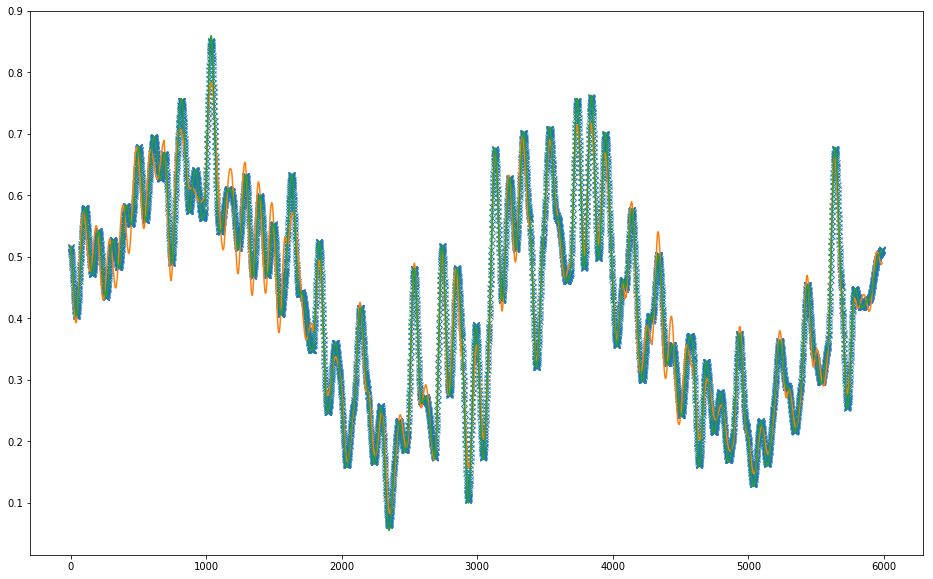

{'Iteration': 1, 'Train error': 0.26796647649551142, 'Test error': 0.020268190396317661, 'Independent error': 4.7586003559676984, 'Training time': 0.0, 'Total time': 5.098524570465088}


In [14]:
######################## TEST FEED-FORWARD MODEL ###########################

t0 = time.time()

for iteration in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(iteration+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    #if i == 0:
    #    model = baseline_model(input_dim, output_dim, 100)
    
    ts = time.time()
    #model.fit(x_train, y_train, epochs=100, verbose = 1)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()
    
    total_time = time.time() - t0
    
    info = {'Iteration': iteration+1, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)

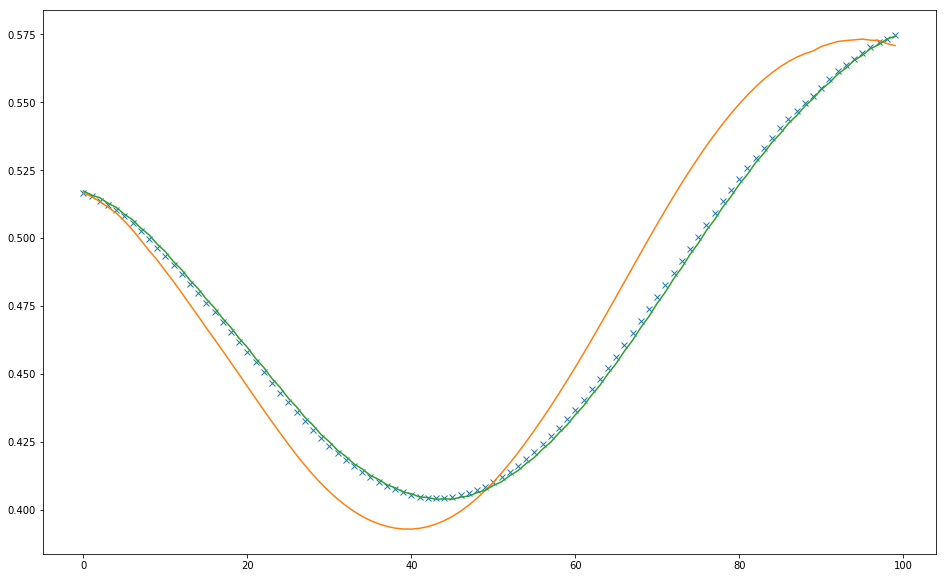

In [15]:
plt.figure(figsize=(16,10))
plt.plot(pred_test[:100,n_nodes-1], 'x')
plt.plot(pred_ind[:100,n_nodes-1])
plt.plot(y_test[0:100, n_nodes-1])
plt.show()

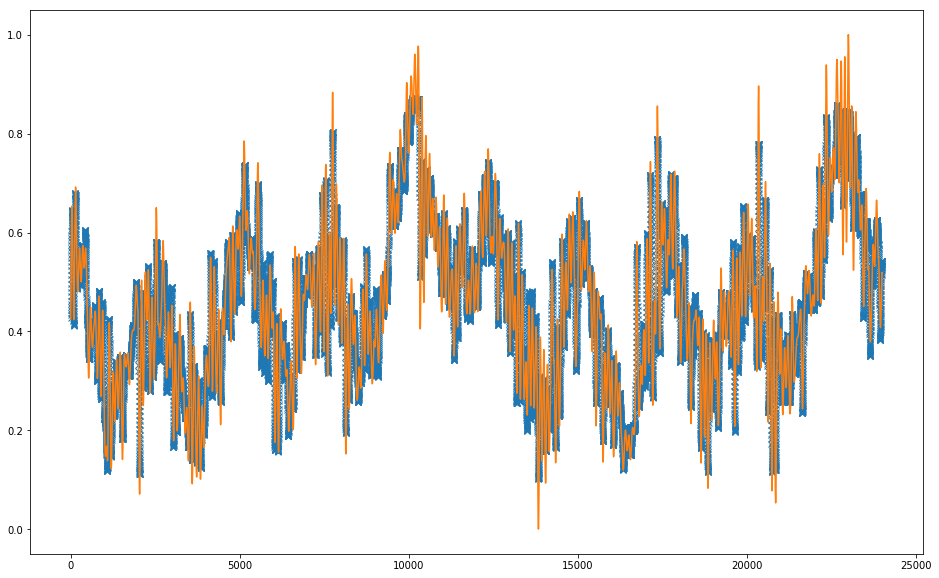

In [19]:
ind_pred_train = independent_predictions(x_train)[:,:n_nodes]
plt.figure(figsize=(16,10))
plt.plot(ind_pred_train[:,n_nodes-1], 'x')
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [16]:
#Export results
np.savetxt("predictions.csv", pred_test_u, delimiter=",")
np.savetxt("preds.csv", pred_ind_u, delimiter=",")
np.savetxt("y_test.csv", y_test_u[:, n_nodes-1], delimiter=",")
np.savetxt("y_train.csv", y_test_u[:, n_nodes-1], delimiter=",")